In [1]:
!pip3 install tensorbay

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 347 kB 49.0 MB/s eta 0:00:01
     |████████████████████████████████| 176 kB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 19.9 MB/s eta 0:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moxing-framework 2.0.0.rc2.4b57a67b requires urllib3>=1.26.2, but you have urllib3 1.25.11 which is incompatible.
modelarts 1.2.4 requires lxml>=4.6.3, but you have lxml 4.4.2 which is incompatible.


In [24]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#os模块主要用于处理文件和目录
import os

import numpy as np
import matplotlib.pyplot as plt

import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
from mindspore.dataset.vision import c_transforms as vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops

# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")


In [25]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#os模块主要用于处理文件和目录
import os

import numpy as np
import matplotlib.pyplot as plt

import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
from mindspore.dataset.vision import c_transforms as vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops

# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")


In [3]:
#利用Tensorbay加载相关数据

from tensorbay import GAS
from tensorbay.dataset import Dataset
import os
os.chdir("test")
gas = GAS("Accesskey-16d5f0f7386759dfec202786fd269ccc")

dataset = Dataset("RP2K", gas)
print(dataset.keys())
segment = dataset["test"]
a = segment[0]
li = segment[0:2000]
for i in li:
    name = i.path
    fp = i.open()
    a = fp.read()
    classification_category = i.label.classification.category
    print(classification_category)
#     print()
    # os.path.exists(path) 判断一个目录是否存在
    if os.path.exists(classification_category):
        with open(classification_category+"/"+name,"wb") as f:
            f.write(a)
    else:
        os.mkdir(classification_category)
        with open(classification_category + "/"+name, "wb") as f:
            f.write(a)
print('finish')

finish


In [26]:
# 整理数据，显示分类类别个数
import os
os.chdir("data")
count = 0
dic = {}
for i in os.listdir():
    dic[i] = count
    count += 1
#print(dic)
print(len(dic))

# 打印class_indexing()

1172


In [38]:
# 配置训练参数
cfg = edict({
    'data_path': 'data',   #训练数据集，如果是zip文件需要解压
    'test_path':'test',     #测试数据集，如果是zip文件需要解压
#     'data_size': 3616,
    'HEIGHT': 224,  # 图片高度
    'WIDTH': 224,  # 图片宽度
    '_R_MEAN': 123.68,
    '_G_MEAN': 116.78,
    '_B_MEAN': 103.94,
    '_R_STD': 1,
    '_G_STD': 1,
    '_B_STD':1,
    '_RESIZE_SIDE_MIN': 256,
    '_RESIZE_SIDE_MAX': 512,
    
    'batch_size': 32,
    'num_class': 1167,     # 分类类别
    'epoch_size': 400,  # 训练次数
    'loss_scale_num':263,
    
    'prefix': 'resnet-ai',
    'directory': './model_resnet_shiwan2222',
    'save_checkpoint_steps': 10,
})


In [28]:
os.chdir("/home/ma-user/work")
print(os.getcwd())

/home/ma-user/work


训练数据集数量： 140576
测试数据集数量： 2000
通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 1148


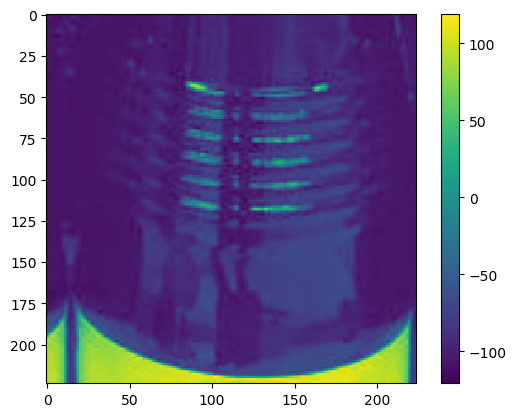

In [33]:
# 数据处理
def read_data(path,config,usage="train"):
    #从目录中读取图像的源数据集。
    dataset = ds.ImageFolderDataset(path,
                                   class_indexing=dic)
    # define map operations
    decode_op = vision.Decode()
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN, cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    horizontal_flip_op = vision.RandomHorizontalFlip()
    channelswap_op = vision.HWC2CHW()
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT, cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)

    if usage == 'train':
        dataset = dataset.map(input_columns="image", operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image", operations=horizontal_flip_op)
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)

    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)

    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000)  # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    else:
        dataset = dataset.batch(1, drop_remainder=True)
    dataset = dataset.repeat(1)
    dataset.map_model = 4

    return dataset
   
de_train = read_data(cfg.data_path,cfg,usage="train")
de_test = read_data(cfg.test_path,cfg,usage="test")
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size())


de_dataset = de_train
data_next = de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'][0,...].shape)
print('一张图像的标签样式：', data_next['label'][0])  # 一共5类，用0-4的数字表达类别。

plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()


In [30]:
"""ResNet."""
def _weight_variable(shape, factor=0.01):
    init_value = np.random.randn(*shape).astype(np.float32) * factor
    return Tensor(init_value)


def _conv3x3(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 3, 3)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=3, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv1x1(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 1, 1)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=1, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _conv7x7(in_channel, out_channel, stride=1):
    weight_shape = (out_channel, in_channel, 7, 7)
    weight = _weight_variable(weight_shape)
    return nn.Conv2d(in_channel, out_channel,
                     kernel_size=7, stride=stride, padding=0, pad_mode='same', weight_init=weight)


def _bn(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=1, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _bn_last(channel):
    return nn.BatchNorm2d(channel, eps=1e-4, momentum=0.9,
                          gamma_init=0, beta_init=0, moving_mean_init=0, moving_var_init=1)


def _fc(in_channel, out_channel):
    weight_shape = (out_channel, in_channel)
    weight = _weight_variable(weight_shape)
    return nn.Dense(in_channel, out_channel, has_bias=True, weight_init=weight, bias_init=0)


class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channel (int): Input channel.
        out_channel (int): Output channel.
        stride (int): Stride size for the first convolutional layer. Default: 1.

    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResidualBlock(3, 256, stride=2)
    """
    expansion = 4

    def __init__(self,
                 in_channel,
                 out_channel,
                 stride=1):
        super(ResidualBlock, self).__init__()

        channel = out_channel // self.expansion
        self.conv1 = _conv1x1(in_channel, channel, stride=1)
        self.bn1 = _bn(channel)

        self.conv2 = _conv3x3(channel, channel, stride=stride)
        self.bn2 = _bn(channel)

        self.conv3 = _conv1x1(channel, out_channel, stride=1)
        self.bn3 = _bn_last(out_channel)

        self.relu = nn.ReLU()

        self.down_sample = False

        if stride != 1 or in_channel != out_channel:
            self.down_sample = True
        self.down_sample_layer = None

        if self.down_sample:
            self.down_sample_layer = nn.SequentialCell([_conv1x1(in_channel, out_channel, stride),
                                                        _bn(out_channel)])
        self.add = ops.Add()

    def construct(self, x): # pylint: disable=missing-docstring
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sample:
            identity = self.down_sample_layer(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out


class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        strides (list):  Stride size in each layer.
        num_classes (int): The number of classes that the training images are belonging to.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        [1, 2, 2, 2],
        >>>        10)
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 strides,
                 num_classes):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of layer_num, in_channels, out_channels list must be 4!")

        self.conv1 = _conv7x7(3, 64, stride=2)
        self.bn1 = _bn(64)
        self.relu = ops.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=strides[0])
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=strides[1])
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=strides[2])
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=strides[3])

        self.mean = ops.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.end_point = _fc(out_channels[3], num_classes)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride):
        """
        Make stage network of ResNet.

        Args:
            block (Cell): Resnet block.
            layer_num (int): Layer number.
            in_channel (int): Input channel.
            out_channel (int): Output channel.
            stride (int): Stride size for the first convolutional layer.

        Returns:
            SequentialCell, the output layer.

        Examples:
            >>> _make_layer(ResidualBlock, 3, 128, 256, 2)
        """
        layers = []

        resnet_block = block(in_channel, out_channel, stride=stride)
        layers.append(resnet_block)

        for _ in range(1, layer_num):
            resnet_block = block(out_channel, out_channel, stride=1)
            layers.append(resnet_block)

        return nn.SequentialCell(layers)

    def construct(self, x): # pylint: disable=missing-docstring
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        out = self.mean(c5, (2, 3))
        out = self.flatten(out)
        out = self.end_point(out)

        return out


def resnet50(class_num=10):
    """
    Get ResNet50 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet50 neural network.

    Examples:
        >>> net = resnet50(10)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 6, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)


def resnet101(class_num=1001):
    """
    Get ResNet101 neural network.

    Args:
        class_num (int): Class number.

    Returns:
        Cell, cell instance of ResNet101 neural network.

    Examples:
        >>> net = resnet101(1001)
    """
    return ResNet(ResidualBlock,
                  [3, 4, 23, 3],
                  [64, 256, 512, 1024],
                  [256, 512, 1024, 2048],
                  [1, 2, 2, 2],
                  class_num)


In [36]:
def get_lr(global_step,
           total_epochs,
           steps_per_epoch,
           lr_init=0.01,
           lr_max=0.1,
           warmup_epochs=5):
    """
    Generate learning rate array.

    Args:
        global_step (int): Initial step of training.
        total_epochs (int): Total epoch of training.
        steps_per_epoch (float): Steps of one epoch.
        lr_init (float): Initial learning rate. Default: 0.01.
        lr_max (float): Maximum learning rate. Default: 0.1.
        warmup_epochs (int): The number of warming up epochs. Default: 5.

    Returns:
        np.array, learning rate array.
    """
    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    if warmup_steps != 0:
        inc_each_step = (float(lr_max) - float(lr_init)) / float(warmup_steps)
    else:
        inc_each_step = 0
    for i in range(int(total_steps)):
        if i < warmup_steps:
            lr = float(lr_init) + inc_each_step * float(i)
        else:
            base = ( 1.0 - (float(i) - float(warmup_steps)) / (float(total_steps) - float(warmup_steps)) )
            lr = float(lr_max) * base * base
            if lr < 0.0:
                lr = 0.0
        lr_each_step.append(lr)

    current_step = global_step
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[current_step:]

    return learning_rate


In [45]:
# 模型超参配置，训练
net=resnet50(class_num=cfg.num_class)
# aa=load_checkpoint("model_resnet_shiwan2222/resnet-ai_1-100_4393.ckpt")
# load_param_into_net(net, aa)
#计算softmax交叉熵。
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#设置Adam优化器
train_step_size = de_train.get_dataset_size()
lr = Tensor(get_lr(global_step=0, total_epochs=cfg.epoch_size, steps_per_epoch=train_step_size))
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)
#opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.002,
#                       0.9, 0.00004, loss_scale=1024.0)
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})
# metric = model.eval(de_test,dataset_sink_mode=False)
# print(metric)
# class_names = dicc
# for i in range(10):
#     test_ = de_train.create_dict_iterator().__next__()
#     test = Tensor(test_['image'], mindspore.float32)
#     predictions = model.predict(test)
#     predictions = predictions.asnumpy()
#     true_label = test_['label'].asnumpy()
#     #显示预测结果
#     p_np = predictions[0, :]
#     pre_label = np.argmax(p_np)
#     print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]])


loss_cb = LossMonitor(per_print_times=train_step_size)
ckpt_config = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, keep_checkpoint_max=1)
ckpoint_cb = ModelCheckpoint(prefix=cfg.prefix, directory=cfg.directory, config=ckpt_config)

print("============== Starting Training ==============")
model.train(100, de_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)
print("finish")


{'acc': 0.8834417208604303}


In [50]:
# 模型acc指标评估
net=resnet50(class_num=cfg.num_class)
# aa=load_checkpoint("model_resnet_shiwan2222/resnet-ai_1-100_4393.ckpt")
# load_param_into_net(net, aa)
#计算softmax交叉熵。
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#设置Adam优化器
train_step_size = de_train.get_dataset_size()
lr = Tensor(get_lr(global_step=0, total_epochs=cfg.epoch_size, steps_per_epoch=train_step_size))
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)
#opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.002,
#                       0.9, 0.00004, loss_scale=1024.0)
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)

model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})
metric = model.eval(de_test,dataset_sink_mode=False)
print(metric)


第0个sample预测结果： 长白山（777）    真实结果： 长白山（777）
第1个sample预测结果： 黄金叶（天叶）    真实结果： 云烟（细支云龙）
第2个sample预测结果： 黄金叶（豫香）    真实结果： 黄金叶（豫香）
第3个sample预测结果： 味事达特级草菇老抽    真实结果： 立白洗洁精金桔1120
第4个sample预测结果： 中南海（5mg）    真实结果： 中南海（5mg）
第5个sample预测结果： 云烟（紫）    真实结果： 云烟（紫）
第6个sample预测结果： 玉溪（中支阿诗玛）    真实结果： 玉溪（中支阿诗玛）
第7个sample预测结果： 屈臣氏盐味苏打汽水    真实结果： 天子（中国心中支）
第8个sample预测结果： 黄金叶（黄金眼）    真实结果： 黄金叶（黄金眼）
第9个sample预测结果： 黄金叶（小黄金）    真实结果： 黄金叶（小黄金）


In [51]:
#抽样预测
net=resnet50(class_num=cfg.num_class)
# aa=load_checkpoint("model_resnet_shiwan2222/resnet-ai_1-100_4393.ckpt")
# load_param_into_net(net, aa)
#计算softmax交叉熵。
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#设置Adam优化器
train_step_size = de_train.get_dataset_size()
lr = Tensor(get_lr(global_step=0, total_epochs=cfg.epoch_size, steps_per_epoch=train_step_size))
opt = Momentum(net.trainable_params(), lr, momentum=0.9, weight_decay=1e-4, loss_scale=cfg.loss_scale_num)
#opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.002,
#                       0.9, 0.00004, loss_scale=1024.0)
loss_scale = FixedLossScaleManager(cfg.loss_scale_num, False)
dicc={}
for i in dic.keys():
    dicc[dic[i]]=i
print(dicc)
model = Model(net, loss_fn=loss, optimizer=opt, loss_scale_manager=loss_scale, metrics={'acc'})
# metric = model.eval(de_test,dataset_sink_mode=False)
# print(metric)
class_names = dicc
for i in range(10):
    test_ = de_train.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    #显示预测结果
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]])


{'acc': 0.8834417208604303}


In [20]:
# 预测

class_names = dicc
for i in range(10):
    test_ = de_train.create_dict_iterator().__next__()
    test = Tensor(test_['image'], mindspore.float32)
    predictions = model.predict(test)
    predictions = predictions.asnumpy()
    true_label = test_['label'].asnumpy()
    #显示预测结果
    p_np = predictions[0, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[0]])


NameError: name 'model' is not defined

In [52]:
#创建文件夹
if not os.path.exists('./flowers1/'):
    os.mkdir('./flowers1/')
param_dict = load_checkpoint("model_resnet_shiwan2222/resnet-ai_1-100_4393.ckpt")

# load the parameter into net
resnet=resnet50(class_num=cfg.num_class)
load_param_into_net(resnet, param_dict)
x = np.random.uniform(-1.0, 1.0, size = [1, 3, cfg.HEIGHT, cfg.WIDTH]).astype(np.float32)   
export(resnet, Tensor(x), file_name = './flowers1/best_model1.onnx', file_format = 'ONNX')


In [15]:
#创建桶，根据自己情况修改路径，将dst_url改为自己的桶路径
import moxing
moxing.file.copy_parallel(src_url='./flowers/best_model.onnx', dst_url='obs://123mrx/flower/onnx/best_model.onnx')


INFO:root:Using MoXing-v2.0.0.rc2.4b57a67b-4b57a67b
INFO:root:Using OBS-Python-SDK-3.20.9.1
